<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [204]:
# ANSWER
titanic_csv = '../../DATA/titanic_train.csv'
titanic = pd.read_csv(titanic_csv, index_col='PassengerId')

In [205]:
# Head
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [206]:
# Shape
titanic.shape

(891, 11)

In [207]:
# Df summary
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [208]:
# Check features for missing values 
titanic.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

* Missing values for age, cabin and embarked

In [209]:
# Descriptive statistics
titanic.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [210]:
# Column names to lower case
titanic.columns = titanic.columns.str.lower()

#### 2.1. Missing value imputation

**Age**

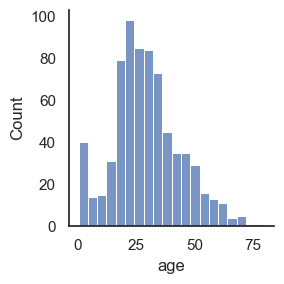

In [211]:
# Plot age distribution
sns.displot(titanic.age, height=3);

In [212]:
# Age has only about 20% missing values > Fill missing values by median values of male and female ages
titanic['age'].fillna(titanic.groupby(by=['sex'])['age'].transform('median'), inplace=True)

**Embarked**

In [213]:
titanic.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [214]:
titanic[titanic.embarked.isna()]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [215]:
#Look up female passengers on internet and set port to S for Southampton
titanic.loc[titanic.embarked.isna(), 'embarked'] = 'S'

#### 2.2. Explore relationship between features and survival

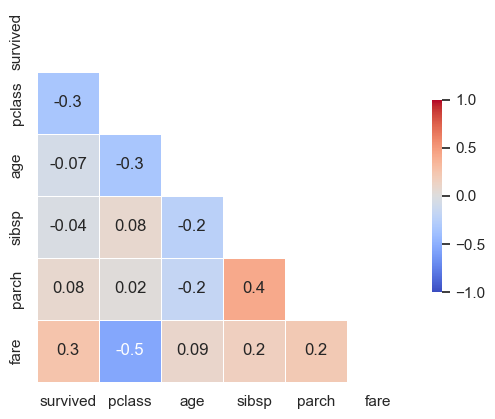

In [216]:
# Correlation heatmap
sns.set_theme(style="white")
plt.figure(figsize=(6,5))

# Generate mask for upper triangle
mask = np.zeros_like(titanic.corr(), dtype=bool) #generate mask of "0's"
mask[np.triu_indices_from(mask)] = True #return upper triangle
# Set diverging colormap
cmap = sns.color_palette('coolwarm', as_cmap=True)
# Draw heatmap with mask and correct aspect ratio
sns.heatmap(titanic.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, fmt='.1g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

* Survival has a slight positive correlation w/ fare and a slight negative correlation w/ pclass

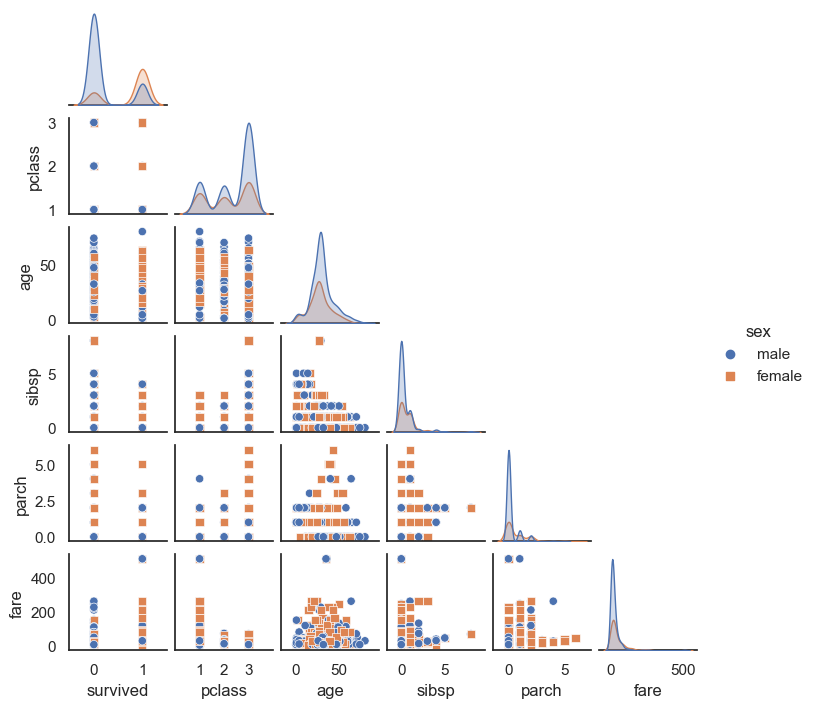

In [217]:
# Plot pairwise relationships
sns.pairplot(titanic, hue='sex', corner=True, height=1.2, markers=["o", "s"]);

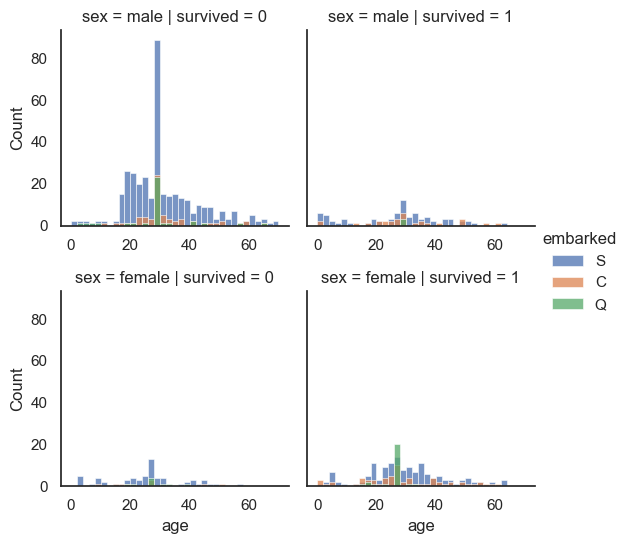

In [218]:
# Plot age distribution in facetgrid to visualize its relationship to variables survived, sex and embarked
g = sns.FacetGrid(titanic, col='survived',  row='sex', hue='embarked', sharex=False, height=2.8)
g.map(sns.histplot, 'age', binwidth=2, binrange=(0, 70))
g.add_legend();

* Male survival age 18-40 esp. embarked in Southampton was low. Male babies survival was disproportionally high
* Female survival age 20-40 was highest. Most females who died embarked in Southampton 

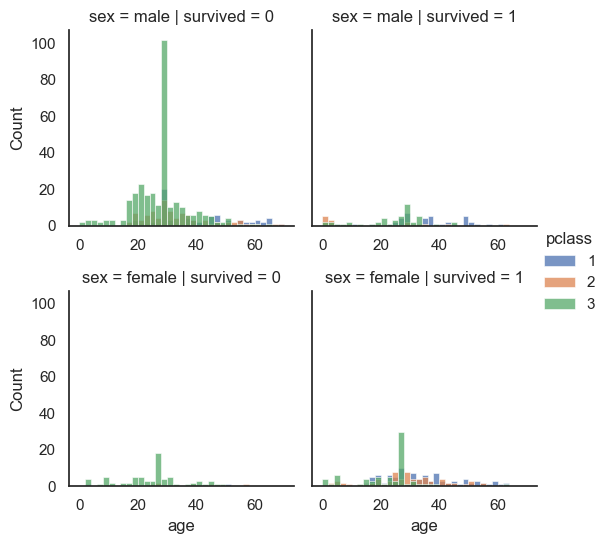

In [219]:
# Plot age distribution in facetgrid to visualize its relationship to variables survived, sex and pclass
g = sns.FacetGrid(titanic, col='survived',  row='sex', hue='pclass', sharex=False, height=2.8)
g.map(sns.histplot, 'age', binwidth=2, binrange=(0, 70))
g.add_legend();

* Male survival age 18-35 from pclass 3 was disproportionally low
* Female survival was better in pclass 2 and 1. Most females who died were from pclass 3 

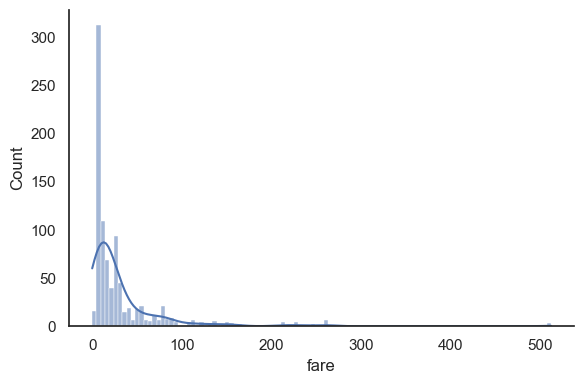

In [220]:
# Plot fare distribution
sns.displot(titanic.fare, kde=True, height=4, aspect=1.5);

In [221]:
# bins
int(np.round(np.sqrt(len(titanic[titanic.fare < 100]))))

29

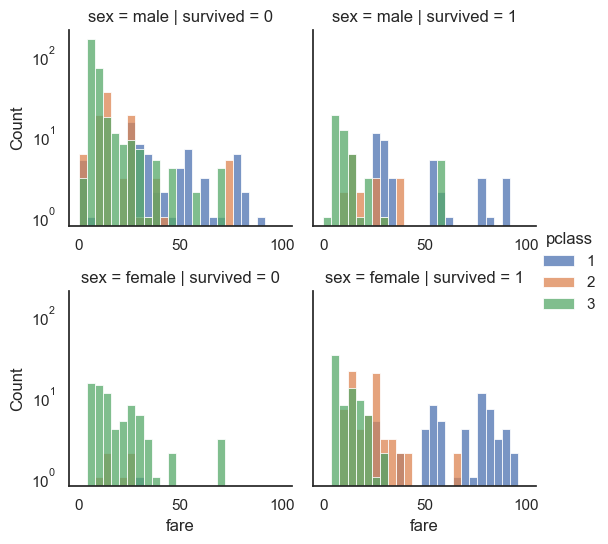

In [222]:
# Plot fare distribution in facetgrid to visualize its relationship to variables survived, sex and pclass
g = sns.FacetGrid(titanic, col='survived',  row='sex', hue='pclass', sharex=False, height=2.8)
g.map(sns.histplot, 'fare', bins=25, binrange=(0, 100)).set(yscale = 'log')
g.add_legend();

* Male death increased w/ decreasing fare 
* Females who died were predominantly traveling in pclass 3

> **Potential features: pclass, sex, fare, age, embarked**

---

**In addition, some code and plots from IOD's answer sheet**

In [223]:
def bar_chart(train, feature):
    survived = train[train['survived']==1][feature].value_counts(normalize=True)*100
    dead = train[train['survived']==0][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=True, figsize=(5,3))
    plt.ylabel('%')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [224]:
survived = titanic[titanic['survived']==1]['sex'].value_counts(normalize=True)*100
dead = titanic[titanic['survived']==0]['sex'].value_counts(normalize=True)*100
df = pd.DataFrame([survived, dead])
df.index = ['Survived', 'Dead']

In [225]:
# Survival percentage by sex
survived

female    68.128655
male      31.871345
Name: sex, dtype: float64

In [226]:
df

,female,male
Survived,68.128655,31.871345
Dead,14.754098,85.245902


In [227]:
def facetgridplot(train, var):
    facet = sns.FacetGrid(train, hue="survived", aspect=4)
    facet.map(sns.kdeplot, var, fill= True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend();

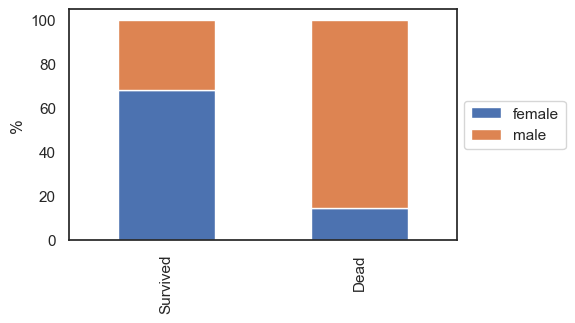

In [228]:
# Sex
bar_chart(titanic, 'sex')

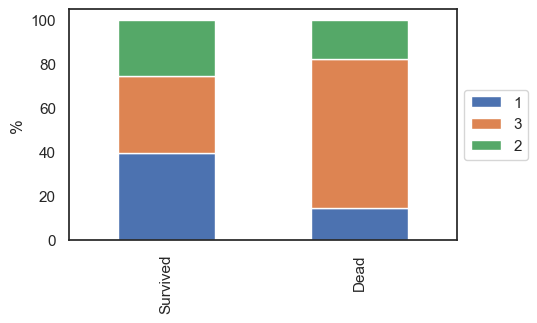

In [229]:
# Pclass
bar_chart(titanic, 'pclass')

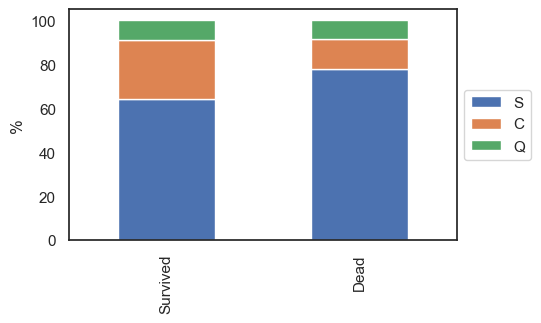

In [230]:
# Embarked
bar_chart(titanic, 'embarked')

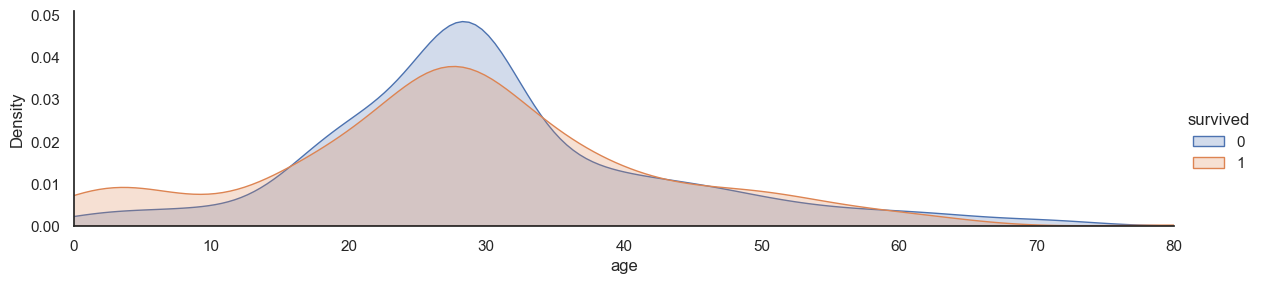

In [231]:
# Age
facetgridplot(titanic, 'age')

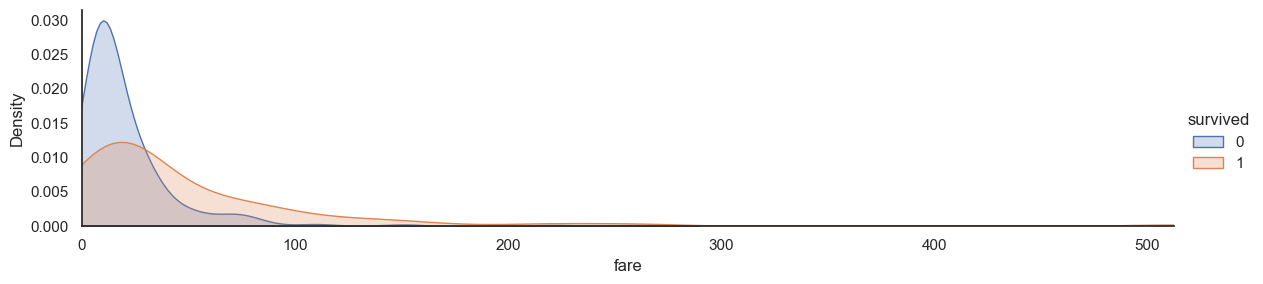

In [232]:
# Fare
facetgridplot(titanic, 'fare')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [233]:
# ANSWER
feature_cols = ['pclass', 'parch']
X = titanic[feature_cols]
y = titanic['survived']

In [234]:
X

,pclass,parch
PassengerId,,
1,3,0
2,1,0
3,3,0
4,1,0
5,3,0
...,...,...
887,2,0
888,1,0
889,3,2


In [235]:
y

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: survived, Length: 891, dtype: int64

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [236]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [237]:
# ANSWER
# Create Model
logreg1 = LogisticRegression() #Note! Employs penalty L2 (ridge) regularisation by default

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [238]:
# ANSWER
# Fit Model
logreg1.fit(X_train, y_train)

LogisticRegression()

In [239]:
X.head(3)

,pclass,parch
PassengerId,,
1,3,0
2,1,0
3,3,0


The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [240]:
# ANSWER
logreg1.coef_

array([[-0.90824213,  0.33432156]])

* pclass coef -0.9 > decrease of survival
* parch coef 0.33 > increase of survival

The computed intercept (`intercept_`) is the 1st element of another array:

In [241]:
# ANSWER
logreg1.intercept_

array([1.40820621])

We can create tuples of the predictor names and coefficients like this:

In [242]:
# ANSWER
print(set(zip(feature_cols, logreg1.coef_[0])))

{('pclass', -0.9082421341469834), ('parch', 0.33432155514777895)}


In [243]:
# or 
print(list(zip(feature_cols, logreg1.coef_[0])))

[('pclass', -0.9082421341469834), ('parch', 0.33432155514777895)]


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [244]:
for col in zip(X_train.columns, logreg1.coef_[0]):
    print('{:<10s} {:+.03f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names
    
# {:<10s} white spaces; {:+.03f} decimals

pclass     -0.908
parch      +0.334


In [245]:
# Return results in df
pd.DataFrame(list(zip(feature_cols, logreg1.coef_[0])), columns = ['feature', 'coef'])

,feature,coef
0,pclass,-0.908242
1,parch,0.334322


**This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.**

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [246]:
# ANSWER
logreg1.score(X_train, y_train)

0.6924157303370787

In [247]:
# format method
print('accuracy model1 (train) = {:7.4f}'.format(logreg1.score(X_train, y_train)))

accuracy model1 (train) =  0.6924


In [248]:
# f-string
print(f'accuracy model1 (train) = {logreg1.score(X_train, y_train):7.4f}')

accuracy model1 (train) =  0.6924


What is the  `accuracy_score` for the test data?

In [249]:
# ANSWER
print(f'accuracy model1 (test) = {logreg1.score(X_test, y_test):7.4f}')

accuracy model1 (test) =  0.6536


What can we say about this result?

ANSWER
* Accuracy score for train and test set are in the same ballpark
* Overfitting seems unlikely

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [250]:
# Re-load dataset
titanic = pd.read_csv(titanic_csv, index_col='PassengerId')
titanic.columns = titanic.columns.str.lower()
titanic.loc[titanic.embarked.isna(), 'embarked'] = 'S'

In [251]:
# ANSWER
titanic['age'].fillna(titanic.age.mean(), inplace=True)
feature_cols = ['pclass', 'parch', 'age']
X = titanic[feature_cols]

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X.head()

,pclass,parch,age
PassengerId,,,
1,3,0,22.0
2,1,0,38.0
3,3,0,26.0
4,1,0,35.0
5,3,0,35.0


In [253]:
# Build Model
logreg2 = LogisticRegression() #Note! Employs penalty L2 (ridge) regularisation by default

# Fit Model
logreg2.fit(X_train, y_train)

# Accuracy score
print('accuracy model2 (train) = {:7.4f}'.format(logreg2.score(X_train, y_train)))
print('accuracy model2 (test) = {:7.4f}'.format(logreg2.score(X_test, y_test)))

accuracy model2 (train) =  0.7247
accuracy model2 (test) =  0.6648


So, including age did little to reduce the variance in our model. Why might this be?

In [254]:
titanic.corr()['age']

survived   -0.069809
pclass     -0.331339
age         1.000000
sibsp      -0.232625
parch      -0.179191
fare        0.091566
Name: age, dtype: float64

ANSWER
- Age is not related to titanic survival
- Age is not dependent of other features already in the model
- Imputing the missing values distorted the distribution too much

Let's see where the model is going wrong by showing the Confusion Matrix:

In [255]:
# ANSWER
y_pred_class = logreg2.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[88 18]
 [42 31]]


In [256]:
logreg2.predict(X_test)[:6]

array([1, 0, 1, 0, 1, 0], dtype=int64)

In [257]:
y_test.iloc[:3]

PassengerId
863    1
224    0
85     1
Name: survived, dtype: int64

Nb. Here is how `confusion_matrix` arranges its output:

In [258]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: Type 2 error (FN: false negative)

Note!

* Important for life and death: type 2 error (FN)

* Important for credit card fraud: type 1 error (FP)

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

In [259]:
logreg2.predict(X_test)[:30]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1], dtype=int64)

In [260]:
X_test.head(3)

,pclass,parch,age
PassengerId,,,
863,1,0,48.000000
224,3,0,29.699118
85,2,0,17.000000


**Always set class of interest to 1!**

In [261]:
logreg2.predict_proba(X_test)[:6] #array w/ prob for 0 and prob for 1 ['survived'] outcome

array([[0.454817  , 0.545183  ],
       [0.80705996, 0.19294004],
       [0.4726803 , 0.5273197 ],
       [0.80705996, 0.19294004],
       [0.27944046, 0.72055954],
       [0.75743591, 0.24256409]])

In [262]:
logreg2.predict_proba(X_test)[:, 1][:6] #array only w/ prob for True/1 ['survived']

array([0.545183  , 0.19294004, 0.5273197 , 0.19294004, 0.72055954,
       0.24256409])

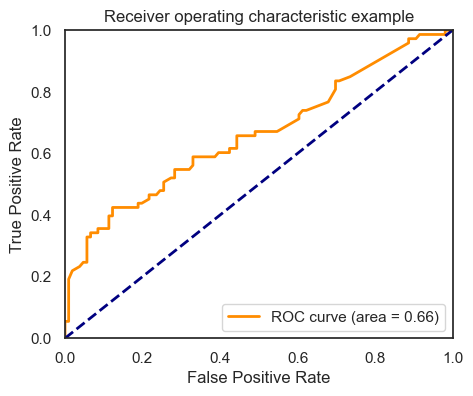

In [263]:
# Generate prediction probabilities for each of the test observations using predict_proba() function rather than just predict
preds = logreg2.predict_proba(X_test)[:,1]

# Store the false positive rate (fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds) #_: threshold

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(5,4))
lw = 2 # line width
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right");

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [264]:
titanic.head(3)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [265]:
titanic_with_dummies = pd.get_dummies(data = titanic,
                                      columns = ['sex', 'embarked', 'pclass'],
                                      prefix = ['sex', 'embarked', 'pclass'])
titanic_with_dummies.head()

,survived,name,age,sibsp,parch,ticket,fare,cabin,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states

In [266]:
pd.get_dummies(data = titanic, columns = ['sex', 'embarked', 'pclass'], prefix = ['sex', 'embarked', 'pclass'], drop_first = True).head(3)

,survived,name,age,sibsp,parch,ticket,fare,cabin,sex_male,embarked_Q,embarked_S,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1


Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [267]:
titanic_with_dummies[["age", "parch", "sex_male", "pclass_1", "pclass_2"]].groupby(["parch", "sex_male", "pclass_1", "pclass_2"])["age"].mean()

parch  sex_male  pclass_1  pclass_2
0      0         0         0           26.090266
                           1           31.953294
                 1         0           35.462390
       1         0         0           29.073054
                           1           33.233619
                 1         0           39.789712
1      0         0         0           18.051859
                           1           24.666667
                 1         0           38.276419
       1         0         0           16.917245
                           1           18.107143
                 1         0           44.071429
2      0         0         0           18.035753
                           1           20.454545
                 1         0           22.230769
       1         0         0           16.110866
                           1           19.866000
                 1         0           21.615000
3      0         0         0           36.000000
                           1     

In [268]:
titanic_with_dummies['age'] = titanic_with_dummies[["age", "parch", "sex_male", "pclass_1", "pclass_2"]].groupby(["parch", "sex_male", "pclass_1", "pclass_2"])["age"].transform(lambda x: x.fillna(x.mean()))

In [269]:
titanic_with_dummies.head(3)

,survived,name,age,sibsp,parch,ticket,fare,cabin,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1


Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [270]:
def get_logreg_score(data, feature_cols, target_col, random_state = 1):
    """
    Function to calculate model accuracy
    """
    # Features and target
    X = data[feature_cols]
    y = data[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    # Build model
    logreg = LogisticRegression(max_iter=1000) #Note! Employs penalty L2 (ridge) regularisation by default
    
    # Fit model
    clf = logreg.fit(X_train, y_train)
    
    # Accuracy score
    print('accuracy logreg (train) = {:7.4f}'.format(clf.score(X_train, y_train)))
    print('accuracy logreg (test) = {:7.4f}'.format(clf.score(X_test, y_test)))

    return clf, X_train, y_train, X_test, y_test

In [271]:
## Alternatively, function from answer sheet

# def get_logreg_score2(data, feature_cols, target_col):
#     X = data[feature_cols]
#     y = data[target_col]

#     # Split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

#     # Build Model
#     logreg = LogisticRegression()

#     # Fit
#     logreg.fit(X_train, y_train)

#     # Score
#     logreg_score = logreg.score(X_test, y_test)

#     # Predict
#     logreg_preds = logreg.predict(X_test)

#     # Predict probability

#     logreg_pred_proba = logreg.predict_proba(X_test)[:,1]

#     # Return accuracy rate
#     return logreg_score, logreg_preds, logreg_pred_proba

In [272]:
def plot_roc_curve(model, X_test, y_test):
    """
    Function to plot roc curve
    """
    # Generate prediction probabilities for each of the test observations using predict_proba() function rather than just predict
    logreg = model
    preds = logreg.predict_proba(X_test)[:,1]
    
    # Store the false positive rate (fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds) #_: threshold
    
    # Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure(figsize=(5,4))
    lw = 2 # line width
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right");    

In [273]:
# ANSWER
# Set features, both numerical and categorical
target_col = 'survived'
feature_cols = ['age', 'sibsp', 'parch', 'pclass_1', 'pclass_2', 'pclass_3']   
data = titanic_with_dummies

model, X_train, y_train, X_test, y_test = get_logreg_score(data, feature_cols, target_col)

accuracy logreg (train) =  0.6980
accuracy logreg (test) =  0.6425


Plot the ROC curve for the new model:

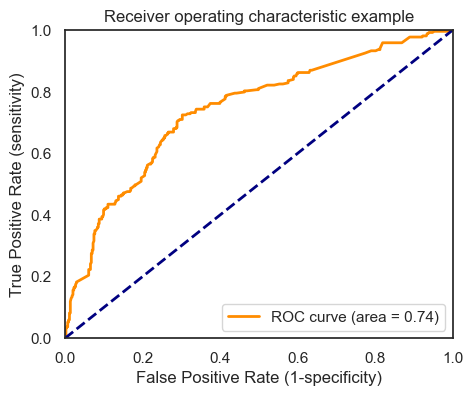

In [274]:
# ANSWER
# Plot ROC curve for training set
plot_roc_curve(model, X_train, y_train)    

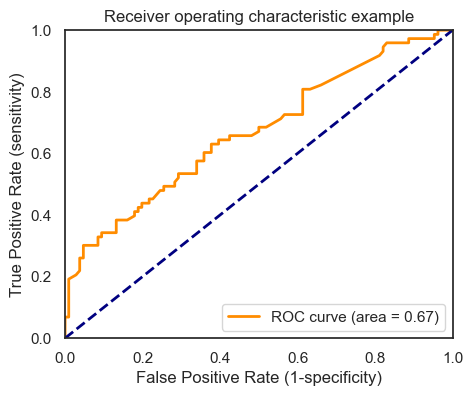

In [275]:
# Plot ROC curve for test set
plot_roc_curve(model, X_test, y_test)  

Can we improve the model by including the remaining features?

In [276]:
# ANSWER
target_col = 'survived'
feature_cols = ['age', 'sibsp', 'parch', 'pclass_1', 'pclass_2', 'pclass_3',
                'embarked_C', 'embarked_Q', 'embarked_S', 'sex_female', 'sex_male']
data = titanic_with_dummies

model, X_train, y_train, X_test, y_test = get_logreg_score(data, feature_cols, target_col)

accuracy logreg (train) =  0.8132
accuracy logreg (test) =  0.7877


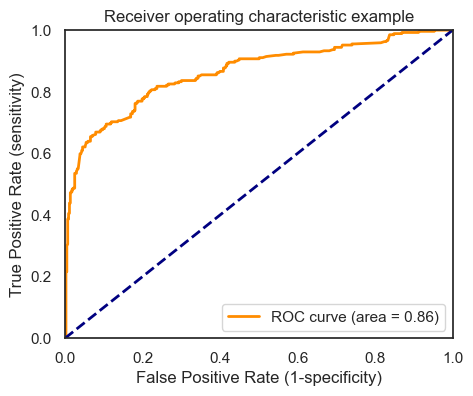

In [277]:
# Plot ROC curve for training set
plot_roc_curve(model, X_train, y_train)    

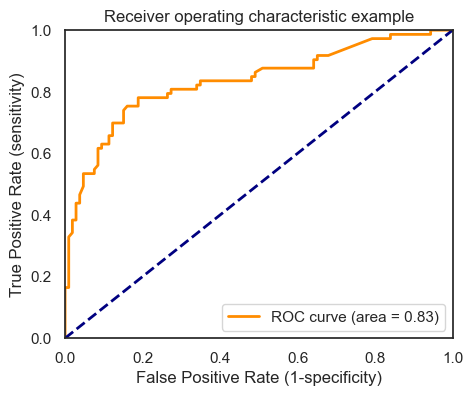

In [278]:
# Plot ROC curve for test set
plot_roc_curve(model, X_test, y_test) 

* Model can significantly be improved (especially for the test set) by including the remaining features

---

**In addition, some code from IOD's answer sheet**

In [279]:
# Actual survival
ttwd = titanic_with_dummies
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                            100 * ttwd[ttwd.sex_male == 1].survived.mean(), ttwd.sex_male.sum(), 
                                            100 * ttwd[ttwd.sex_female == 1].survived.mean(), ttwd.sex_female.sum(),
                                            100 * ttwd[ttwd.age < 16].survived.mean(), len(ttwd[ttwd.age < 16])))

Male survival: 18.89% of 577
Female survival: 74.20% of 314
Child survival: 59.04% of 83


In [280]:
ttwd[ttwd['sex_male'] == 1]['survived'].mean()

0.18890814558058924

In [281]:
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Build Model
logreg = LogisticRegression(max_iter=1000)

# Fit
logreg.fit(X_train, y_train)

# Make a data frame of results, including actual and predicted response:
y_hat = logreg.predict(X)
y_hats = pd.Series(y_hat, index = X.index)
y_hatdf = pd.DataFrame({'y_hat': y_hats})
y_actuals = pd.Series(y, index = X.index)    # names 'y', 'y_test' are in use
y_actualdf = pd.DataFrame({'y_actual': y_actuals})   
ttall = y_hatdf.join(y_actualdf).join(X)
ttall.head()

,y_hat,y_actual,age,sibsp,parch,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,sex_female,sex_male
PassengerId,,,,,,,,,,,,,
1,0,0,22.0,1,0,0,0,1,0,0,1,0,1
2,1,1,38.0,1,0,1,0,0,1,0,0,1,0
3,1,1,26.0,0,0,0,0,1,0,0,1,1,0
4,1,1,35.0,1,0,1,0,0,0,0,1,1,0
5,0,0,35.0,0,0,0,0,1,0,0,1,0,1


In [282]:
y_hat[:5]

array([0, 1, 1, 1, 0], dtype=int64)

In [283]:
y_hats[:5]

PassengerId
1    0
2    1
3    1
4    1
5    0
dtype: int64

In [284]:
y_hatdf.head(3)

,y_hat
PassengerId,
1,0
2,1
3,1


In [285]:
# Predicted survival
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                                    100 * ttall[ttall.sex_male == 1].y_hat.mean(), ttall.sex_male.sum(), 
                                                    100 * ttall[ttall.sex_female == 1].y_hat.mean(), ttall.sex_female.sum(),
                                                    100 * ttall[ttall.age < 16].y_hat.mean(), len(ttall[ttall.age < 16])))

Male survival:  5.37% of 577
Female survival: 87.58% of 314
Child survival: 53.01% of 83


## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [286]:
## 1. Removing random_state
target_col = 'survived'
feature_cols = ['age', 'sibsp', 'parch', 'pclass_1', 'pclass_2', 'pclass_3', 'embarked_C', 'embarked_Q', 'embarked_S', 'sex_female', 'sex_male']
data = titanic_with_dummies

model, X_train, y_train, X_test, y_test = get_logreg_score(data, feature_cols, target_col, random_state=None)

accuracy logreg (train) =  0.8132
accuracy logreg (test) =  0.7877


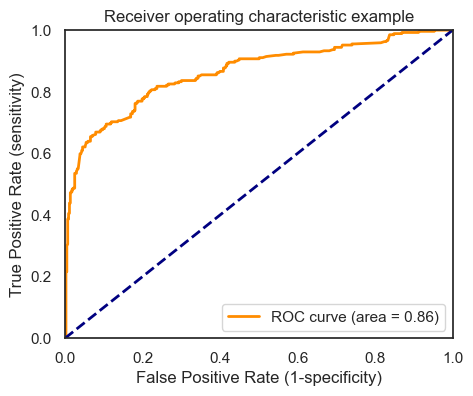

In [287]:
# Plot ROC curve for training set
plot_roc_curve(model, X_train, y_train)    

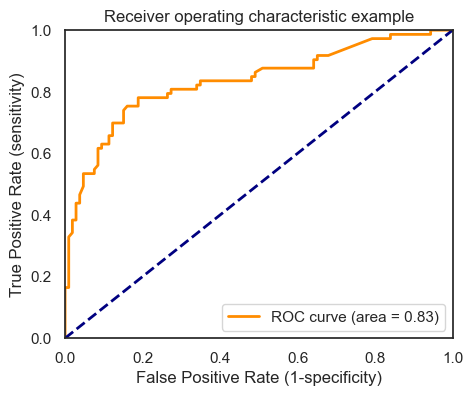

In [288]:
# Plot ROC curve for test set
plot_roc_curve(model, X_test, y_test) 

* Removing random_state did (in this instance) not change the result

In [289]:
## 2. Performing cross-validation

# Features and target
target_col = 'survived'
feature_cols = ['age', 'sibsp', 'parch', 'pclass_1', 'pclass_2', 'pclass_3', 'embarked_C', 'embarked_Q', 'embarked_S', 'sex_female', 'sex_male']
data = titanic_with_dummies

# Model
logreg = LogisticRegression(max_iter=1000)

# Cross validation
scores = cross_val_score(logreg, data[feature_cols], data[target_col], cv=10)
scores

array([0.77777778, 0.79775281, 0.7752809 , 0.80898876, 0.78651685,
       0.78651685, 0.78651685, 0.7752809 , 0.83146067, 0.85393258])

In [290]:
print("%0.2f mean accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.80 mean accuracy with a standard deviation of 0.02


In [291]:
## 3. Look at tpr and fpr vectors for best model

# Features and target
target_col = 'survived'
feature_cols = ['age', 'sibsp', 'parch', 'pclass_1', 'pclass_2', 'pclass_3', 'embarked_C', 'embarked_Q', 'embarked_S', 'sex_female', 'sex_male']
data = titanic_with_dummies

# Split data
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col], test_size = 0.2, random_state = 1)

# Fit model
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

In [292]:
# Predict survival for test set
y_pred_test = clf.predict(X_test)

# Confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_test))

[[90 16]
 [22 51]]


In [293]:
# Confusion matrix
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


* Type 2 error (FN) halved compared to first confusion matrix above

In [294]:
# Classification report
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       106
           1       0.76      0.70      0.73        73

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



**Reminder:**

* True Positive Rate (TPR), **recall** or sensitivity = $\frac{TP}{TP+FN}$ (focus on completeness)

* **precision** or specificity = $\frac{TP}{TP+FP}$ (focus on exactness)

* False Positive Rate (FPR) or 1-specificity = $\frac{FP}{FP+TN}$

* **f1-score** (harmonic mean of precison and recall) = $\frac{2 * precison * recall}{precision + recall}$

* **accuracy** = $\frac{TP+TN}{Total}$

---

**Additional code from IOD's answer sheet**

In [295]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_test)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[90 16]
 [22 51]]


**Classification Accuracy:** Overall, how often is the classifier correct?

In [296]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_test))

0.7877094972067039
0.7877094972067039


**Classification Error:** Overall, how often is the classifier incorrect?

Also known as "Misclassification Rate"

In [297]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_test))

0.2122905027932961
0.2122905027932961


**Sensitivity:** When the actual value is positive, how often is the prediction correct?

Something we want to maximize
How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"
- TP / all positive
    - all positive = TP + FN

In [298]:
sensitivity = TP / float(FN + TP)
print(sensitivity)
print(metrics.recall_score(y_test, y_pred_test))

0.6986301369863014
0.6986301369863014


**Specificity:** When the actual value is negative, how often is the prediction correct?

Something we want to maximize
How "specific" (or "selective") is the classifier in predicting positive instances?
TN / all negative
all negative = TN + FP

In [299]:
specificity = TN / (TN + FP)

print(specificity)

0.8490566037735849


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [300]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.1509433962264151
0.15094339622641506


**Precision:** When a positive value is predicted, how often is the prediction correct?

How "precise" is the classifier when predicting positive instances?

In [301]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_test))

0.7611940298507462
0.7611940298507462




---



---



> > > > > > > > > © 2022 Institute of Data


---



---



